In [1]:
# 환경 설정
import os
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

# 시드 고정 유틸리티 함수
def seed_everything(seed=42):
    """모든 난수 생성기 시드를 고정하는 함수"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"🔒 모든 시드를 {seed}로 고정완료")

# 초기 시드 고정
seed_everything(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
🔒 모든 시드를 42로 고정완료


# Stage 3 위조 비율 실험: 다양한 위조 비율에서의 MIL 모델 성능 분석

이 노트북은 Stage 2에서 생성한 **다양한 위조 비율**(5%, 10%, 20%, 30%, 50%) MIL Bag 데이터를 입력으로 받아 모델 성능을 비교 실험합니다.

**실험 목표:**
- 낮은 위조 비율(5%, 10%)에서의 모델 성능 평가
- 위조 탐지 Recall 유지 능력 분석 (위조를 놓치지 않는 능력)
- Matched vs Shift 모드 성능 비교
- 모델별 위조 비율 적응성 분석

**실험 모드:**
1. **Matched 모드**: 각 비율(5/10/20/30%)별로 독립적으로 학습/평가
2. **Shift 모드**: 30% 비율로 학습 → 다양한 비율(5/10/20/30%)로 평가

**평가 모델:**
- Basic Attention MIL
- **Gated Attention MIL** 🆕 (Gate mechanism으로 attention 조절)
- DSMIL (Dual-stream MIL)
- Mean Pooling (베이스라인)

**중요한 연구 질문:**
- 위조 비율이 낮아질수록 성능이 얼마나 저하되는가?
- 어떤 모델이 낮은 위조 비율에서 더 강건한가?
- Gate mechanism이 위조 비율 변화에 대한 강건성을 제공하는가?
- 30% 학습 모델이 5% 테스트에서도 잘 동작하는가? (도메인 적응)

In [2]:
# 위조 비율별 데이터 로드 유틸리티
def ratio_to_tag(pos_ratio: float) -> str:
    """비율을 파일명 태그로 변환: 0.05 → '05p', 0.30 → '30p'"""
    return f"{int(round(pos_ratio*100)):02d}p"

def load_forgery_data(bags_dir, margin='0.4', ratios=[0.05, 0.10, 0.20, 0.30, 0.50]):
    """다양한 위조 비율의 MIL Bag 데이터를 로드"""
    data_dict = {}
    
    print("📁 위조 비율별 데이터 로딩 중...")
    print("=" * 60)
    
    for ratio in ratios:
        rtag = ratio_to_tag(ratio)
        print(f"  Loading {rtag} ({ratio:.0%}) datasets...")
        
        # 파일 경로 생성
        train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_train.pkl')
        val_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_val.pkl')
        test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        
        # 데이터 로드
        try:
            with open(train_pkl, 'rb') as f:
                train_data = pickle.load(f)
            with open(val_pkl, 'rb') as f:
                val_data = pickle.load(f)
            with open(test_pkl, 'rb') as f:
                test_data = pickle.load(f)
                
            data_dict[rtag] = {
                'train': train_data,
                'val': val_data,
                'test': test_data,
                'ratio': ratio
            }
            
            print(f"    ✅ {rtag}: Train={len(train_data['labels'])}, Val={len(val_data['labels'])}, Test={len(test_data['labels'])}")
            
        except FileNotFoundError as e:
            print(f"    ❌ {rtag}: 파일을 찾을 수 없습니다 - {e}")
            continue
    
    print("=" * 60)
    print(f"✅ 총 {len(data_dict)}개 비율 데이터셋 로드 완료")
    return data_dict

def load_shift_data(bags_dir, margin='0.4', train_ratio=0.30, eval_ratios=[0.05, 0.10, 0.20, 0.30, 0.50]):
    """Shift 모드용 데이터 로드: 30% 학습 + 다양한 비율 평가"""
    print("📁 Shift 모드 데이터 로딩 중...")
    print("=" * 60)
    
    # 학습용 데이터 (30%)
    train_rtag = ratio_to_tag(train_ratio)
    train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_train.pkl')
    val_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_val.pkl')
    # Shift 전용 네임스페이스 파일이 있으면 우선 사용
    train_pkl_shift = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_train_shiftbase.pkl')
    val_pkl_shift   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{train_rtag}_random_val_shiftbase.pkl')
    if os.path.exists(train_pkl_shift):
        train_pkl = train_pkl_shift
    if os.path.exists(val_pkl_shift):
        val_pkl = val_pkl_shift


    
    with open(train_pkl, 'rb') as f:
        train_data = pickle.load(f)
    with open(val_pkl, 'rb') as f:
        val_data = pickle.load(f)
    
    print(f"  학습용 {train_rtag} ({train_ratio:.0%}): Train={len(train_data['labels'])}, Val={len(val_data['labels'])}")
    
    # 평가용 데이터들
    eval_data = {}
    for ratio in eval_ratios:
        rtag = ratio_to_tag(ratio)
        test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test_shift_{rtag}.pkl')
        
        # Shift 평가 파일이 없으면 일반 테스트 파일 사용
        if not os.path.exists(test_pkl):
            test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        
        try:
            with open(test_pkl, 'rb') as f:
                test_data = pickle.load(f)
            eval_data[rtag] = {
                'test': test_data,
                'ratio': ratio
            }
            print(f"  평가용 {rtag} ({ratio:.0%}): Test={len(test_data['labels'])}")
        except FileNotFoundError:
            print(f"  ❌ {rtag}: 평가 파일을 찾을 수 없습니다")
    
    print("=" * 60)
    print(f"✅ Shift 모드 데이터 로드 완료: 학습 {train_rtag} + 평가 {len(eval_data)}개")
    
    return {
        'train': train_data,
        'val': val_data,
        'eval_sets': eval_data,
        'train_ratio': train_ratio
    }

print("✅ 데이터 로드 유틸리티 정의 완료")

✅ 데이터 로드 유틸리티 정의 완료


In [3]:
# 위조 비율별 데이터 로드
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
RATIOS = [0.05, 0.10, 0.20, 0.30, 0.50]

# Matched 모드용 데이터 로드
matched_data = load_forgery_data(bags_dir, embedding_margin, RATIOS)

# Shift 모드용 데이터 로드
shift_data = load_shift_data(bags_dir, embedding_margin, train_ratio=0.30, eval_ratios=RATIOS)

# Instance mean 계산 함수: (10,5,256) → (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

print("\n🔄 Instance mean 계산 중...")
# Matched 데이터 전처리
for rtag, data in matched_data.items():
    data['train_features'] = to_instance_means(data['train']['bags'])
    data['val_features'] = to_instance_means(data['val']['bags'])
    data['test_features'] = to_instance_means(data['test']['bags'])
    
# Shift 데이터 전처리
shift_data['train_features'] = to_instance_means(shift_data['train']['bags'])
shift_data['val_features'] = to_instance_means(shift_data['val']['bags'])
for rtag, eval_set in shift_data['eval_sets'].items():
    eval_set['test_features'] = to_instance_means(eval_set['test']['bags'])

print("✅ 모든 데이터 전처리 완료")

📁 위조 비율별 데이터 로딩 중...
  Loading 05p (5%) datasets...
    ✅ 05p: Train=3600, Val=1200, Test=1200
  Loading 10p (10%) datasets...
    ✅ 10p: Train=3600, Val=1200, Test=1200
  Loading 20p (20%) datasets...
    ✅ 20p: Train=3600, Val=1200, Test=1200
  Loading 30p (30%) datasets...
    ✅ 30p: Train=3600, Val=1200, Test=1200
  Loading 50p (50%) datasets...
    ✅ 50p: Train=3600, Val=1200, Test=1200
✅ 총 5개 비율 데이터셋 로드 완료
📁 Shift 모드 데이터 로딩 중...
  학습용 30p (30%): Train=3600, Val=1200
  평가용 05p (5%): Test=1200
  평가용 10p (10%): Test=1200
  평가용 20p (20%): Test=1200
  평가용 30p (30%): Test=1200
  평가용 50p (50%): Test=1200
✅ Shift 모드 데이터 로드 완료: 학습 30p + 평가 5개

🔄 Instance mean 계산 중...
✅ 모든 데이터 전처리 완료


In [4]:
# Dataset 클래스 (on‑the‑fly Tensor 변환)
class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

def create_dataloaders(features, labels, batch_size=16):
    """Features와 labels로부터 DataLoader 생성"""
    train_loader = DataLoader(MILDataset(features['train'], labels['train']), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(MILDataset(features['val'], labels['val']), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(MILDataset(features['test'], labels['test']), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

print("✅ Dataset 클래스 및 DataLoader 유틸리티 정의 완료")

✅ Dataset 클래스 및 DataLoader 유틸리티 정의 완료


In [5]:
# WeightedBCE 손실함수 정의
class WeightedBCE(nn.Module):
    """Weighted Binary Cross Entropy Loss - False Positive에 더 큰 가중치 부여"""
    def __init__(self, fp_weight=2.0):
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        # False Positive (label=0인데 예측이 1)에 더 큰 가중치
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

print("✅ WeightedBCE 손실함수 클래스 정의 완료")
print(f"   FP Weight: 2.0 (baseline과 동일)")

✅ WeightedBCE 손실함수 클래스 정의 완료
   FP Weight: 2.0 (baseline과 동일)


In [6]:
# MIL 모델 정의: Attention vs DSMIL vs Gated Attention vs Mean Pooling

class AttentionMIL(nn.Module):
    """기본 Attention-based MIL 모델"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Attention mechanism
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        # He initialization for ReLU layers
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        # Xavier for others
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        # Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        # Attention calculation
        a = torch.tanh(self.att_fc1(h))  # (B, N, hidden_dim)
        a = self.att_fc2(a).squeeze(-1)  # (B, N)
        weights = torch.softmax(a, dim=1)  # (B, N)
        
        # Weighted aggregation
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)  # (B, hidden_dim)
        bag_repr = self.dropout(bag_repr)
        
        # Classification
        logits = self.classifier(bag_repr).squeeze(-1)  # (B,)
        return logits, weights

class GatedAttentionMIL(nn.Module):
    """Gated Attention MIL 모델 - Gate mechanism으로 attention 조절"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Attention branch
        self.attention_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.attention_fc2 = nn.Linear(hidden_dim, 1)
        
        # Gate branch  
        self.gate_fc1 = nn.Linear(hidden_dim, hidden_dim)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        # He initialization for ReLU layers
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        
        # Xavier for attention branch
        nn.init.xavier_uniform_(self.attention_fc1.weight)
        nn.init.zeros_(self.attention_fc1.bias)
        nn.init.xavier_uniform_(self.attention_fc2.weight)
        nn.init.zeros_(self.attention_fc2.bias)
        
        # Xavier for gate branch
        nn.init.xavier_uniform_(self.gate_fc1.weight)
        nn.init.zeros_(self.gate_fc1.bias)
        
        # Classifier
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        # Instance feature transformation: (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        # Attention branch
        attention = torch.tanh(self.attention_fc1(h))  # (B, N, hidden_dim)
        
        # Gate branch (vector gate)
        gate = torch.sigmoid(self.gate_fc1(h))  # (B, N, hidden_dim) - vector gate
        
        # Combine attention with gate (canonical: vector-level gating)
        scores = self.attention_fc2(attention * gate).squeeze(-1)  # (B, N)
        
        # Softmax normalization
        weights = torch.softmax(scores, dim=1)  # (B, N)
        
        # Weighted aggregation
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)  # (B, hidden_dim)
        bag_repr = self.dropout(bag_repr)
        
        # Classification
        logits = self.classifier(bag_repr).squeeze(-1)  # (B,)
        return logits, weights

class DSMILModel(nn.Module):
    """DSMIL 보강: instance branch + critical instance 기반 cross-attention + dual-stream concat
    - 반환: bag_logits, attn_weights(critical-conditioned), inst_logits, top_idx"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        # Instance classifier (instance branch)
        self.inst_cls = nn.Linear(hidden_dim, 1)
        
        # Cross-attention (critical instance -> query)
        self.key_proj   = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.query_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.val_proj   = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        # Max-pool stream
        self.max_proj = nn.Linear(hidden_dim, hidden_dim)
        
        # Final classifier on concat([cross-attn bag repr, max-pooled repr])
        self.classifier = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, x):
        # x: (B, N, D)
        h = self.enc(x)                        # (B, N, H)
        inst_logits = self.inst_cls(h).squeeze(-1)   # (B, N)
        
        # critical instance (top‑1 by instance score)
        with torch.no_grad():
            top_idx = inst_logits.sigmoid().argmax(dim=1)  # (B,)
        
        B, N, H = h.shape
        batch_idx = torch.arange(B, device=h.device)
        h_star = h[batch_idx, top_idx]                     # (B, H)
        
        # cross-attention: score_i = <K h_i, Q h_star> / sqrt(H)
        K = self.key_proj(h)                               # (B, N, H)
        Q = self.query_proj(h_star).unsqueeze(-1)          # (B, H, 1)
        attn_score = torch.bmm(K, Q).squeeze(-1) / (H ** 0.5)  # (B, N)
        attn_w = torch.softmax(attn_score, dim=1)          # (B, N)
        
        V = self.val_proj(h)                               # (B, N, H)
        attn_repr = torch.sum(attn_w.unsqueeze(-1) * V, dim=1)  # (B, H)
        
        # max-pool stream
        max_repr = torch.max(torch.relu(self.max_proj(h)), dim=1)[0]  # (B, H)
        
        # concat & classify
        bag_repr = torch.cat([attn_repr, max_repr], dim=1)            # (B, 2H)
        bag_logits = self.classifier(bag_repr).squeeze(-1)            # (B,)
        return bag_logits, attn_w, inst_logits, top_idx

class MeanPoolingModel(nn.Module):
    """베이스라인: 단순 평균 풀링 모델"""
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        bag_mean = x.mean(dim=1)  # (B, input_dim)
        logits = self.fc(bag_mean).squeeze(-1)  # (B,)
        return logits

print("✅ 모델 클래스 정의 완료:")
print("  - AttentionMIL: 기본 attention mechanism")
print("  - GatedAttentionMIL: Gate로 조절되는 attention mechanism") 
print("  - DSMILModel: Cross-attention based DSMIL (Instance + Cross-attention + Max pooling)")
print("  - MeanPoolingModel: 베이스라인 (단순 평균)")

✅ 모델 클래스 정의 완료:
  - AttentionMIL: 기본 attention mechanism
  - GatedAttentionMIL: Gate로 조절되는 attention mechanism
  - DSMILModel: Cross-attention based DSMIL (Instance + Cross-attention + Max pooling)
  - MeanPoolingModel: 베이스라인 (단순 평균)


In [7]:
# 모델 학습 및 평가 함수 (다중 모델 비교용 - DSMIL instance loss 지원)
from sklearn.metrics import precision_score, recall_score

def is_attention_model(model):
    """Attention 기반 모델인지 확인 (AttentionMIL, GatedAttentionMIL, DSMILModel)"""
    return isinstance(model, (AttentionMIL, GatedAttentionMIL, DSMILModel))

def train_one_epoch(model, optimizer, loader, criterion, inst_loss_weight=0.0):
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(X)
        if isinstance(out, (tuple, list)) and len(out) == 4:
            # DSMIL with instance loss
            logits, _, inst_logits, top_idx = out
            bag_loss = criterion(logits, y)
            if inst_loss_weight > 0:
                batch_idx = torch.arange(y.size(0), device=y.device)
                top_inst_logits = inst_logits[batch_idx, top_idx]
                inst_loss = nn.BCEWithLogitsLoss()(top_inst_logits, y)
                loss = bag_loss + inst_loss_weight * inst_loss
            else:
                loss = bag_loss
        elif isinstance(out, (tuple, list)):
            # AttentionMIL, GatedAttentionMIL
            logits, _ = out
            loss = criterion(logits, y)
        else:
            # MeanPoolingModel
            logits = out
            loss = criterion(logits, y)
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    attention_weights_all = []
    
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            out = model(X)
            if isinstance(out, (tuple, list)) and len(out) == 4:
                # DSMIL
                logits, attention_weights, _, _ = out
                attention_weights_all.append(attention_weights.cpu().numpy())
            elif isinstance(out, (tuple, list)):
                # AttentionMIL, GatedAttentionMIL
                logits, attention_weights = out
                attention_weights_all.append(attention_weights.cpu().numpy())
            else:
                # MeanPoolingModel
                logits = out
                
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all, zero_division=0.0)
    precision = precision_score(labels_all, preds_all, zero_division=0.0)
    recall = recall_score(labels_all, preds_all, zero_division=0.0)
    
    # Combine attention weights if available
    attention_weights_combined = np.concatenate(attention_weights_all, axis=0) if attention_weights_all else None
    
    return {
        'loss': total_loss / len(loader.dataset),
        'accuracy': acc,
        'auc': auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'probs': np.array(probs_all),
        'labels': np.array(labels_all),
        'preds': np.array(preds_all),
        'attention_weights': attention_weights_combined
    }

def train_model(model, optimizer, scheduler, train_loader, val_loader, criterion, 
                max_epochs=10, patience=3, name='model', inst_loss_weight=0.0):
    """모델 학습 (Early Stopping 포함) - DSMIL instance loss 지원"""
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': []}
    
    for epoch in range(1, max_epochs + 1):
        # Training
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion, inst_loss_weight)
        
        # Validation
        val_results = evaluate(model, val_loader, criterion)
        val_loss, val_acc, val_auc, val_f1 = val_results['loss'], val_results['accuracy'], val_results['auc'], val_results['f1']
        
        # Log metrics
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        
        # Learning rate scheduling
        scheduler.step(val_auc)
        
        # Best model tracking
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, history

print("✅ 학습/평가 함수 정의 완료 (DSMIL instance loss + GatedAttention 지원)")
print("  - train_one_epoch: instance loss 가중치 지원")
print("  - evaluate: 다중 출력 모델 지원 (AttentionMIL, GatedAttentionMIL, DSMIL)")
print("  - train_model: DSMIL instance loss 가중치 지원")

✅ 학습/평가 함수 정의 완료 (DSMIL instance loss + GatedAttention 지원)
  - train_one_epoch: instance loss 가중치 지원
  - evaluate: 다중 출력 모델 지원 (AttentionMIL, GatedAttentionMIL, DSMIL)
  - train_model: DSMIL instance loss 가중치 지원


In [8]:
# ==============================================================================
# Matched 모드 실험: 각 비율별로 독립적으로 학습/평가
# ==============================================================================

print("🔬 Matched 모드 실험 시작")
print("=" * 80)
print("각 위조 비율별로 독립적으로 모델을 학습하고 평가합니다.")
print("목표: 위조 비율 변화에 따른 모델 성능 변화 분석")
print("=" * 80)

# 실험 설정
criterion = WeightedBCE(fp_weight=2.0)
learning_rate = 1e-3
max_epochs = 10
patience = 3
scheduler_patience = 1
batch_size = 16

# 모델 리스트 (GatedAttentionMIL 추가)
MODEL_CLASSES = {
    'AttentionMIL': AttentionMIL,
    'GatedAttentionMIL': GatedAttentionMIL,  # 🆕 새로 추가된 모델
    'DSMIL': DSMILModel,
    'MeanPooling': MeanPoolingModel
}

# 결과 저장
matched_results = {}

# 각 비율별로 실험
for rtag, data in matched_data.items():
    ratio = data['ratio']
    print(f"\n{'='*60}")
    print(f"🎯 {rtag} ({ratio:.0%}) 위조 비율 실험")
    print(f"{'='*60}")
    
    # DataLoader 생성
    features = {
        'train': data['train_features'],
        'val': data['val_features'],
        'test': data['test_features']
    }
    labels = {
        'train': data['train']['labels'],
        'val': data['val']['labels'],
        'test': data['test']['labels']
    }
    
    train_loader, val_loader, test_loader = create_dataloaders(features, labels, batch_size)
    
    matched_results[rtag] = {'ratio': ratio, 'models': {}}
    
    # 각 모델별로 학습
    for model_name, model_class in MODEL_CLASSES.items():
        print(f"\n🚀 {model_name} 학습 중... (비율: {rtag})")
        
        # 시드 고정 (재현성)
        seed_everything(42)
        
        # 모델 생성
        if model_name == 'MeanPooling':
            model = model_class(input_dim=256).to(device)
        else:
            model = model_class(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
        
        # Optimizer & Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=False
        )
        
        # 학습
        model, history = train_model(
            model, optimizer, scheduler, train_loader, val_loader, criterion,
            max_epochs=max_epochs, patience=patience, name=f'{model_name}_{rtag}'
        )
        
        # 평가
        val_results = evaluate(model, val_loader, criterion)
        test_results = evaluate(model, test_loader, criterion)
        
        # 결과 저장
        matched_results[rtag]['models'][model_name] = {
            'model': model,
            'history': history,
            'val': val_results,
            'test': test_results
        }
        
        print(f"  ✅ {model_name} 완료: Val AUC={val_results['auc']:.3f}, Test AUC={test_results['auc']:.3f}")
        print(f"     Test Recall={test_results['recall']:.3f}, Test F1={test_results['f1']:.3f}")

print("\n" + "="*80)
print("🏆 Matched 모드 실험 완료!")
print("="*80)

🔬 Matched 모드 실험 시작
각 위조 비율별로 독립적으로 모델을 학습하고 평가합니다.
목표: 위조 비율 변화에 따른 모델 성능 변화 분석

🎯 05p (5%) 위조 비율 실험

🚀 AttentionMIL 학습 중... (비율: 05p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ AttentionMIL 완료: Val AUC=0.665, Test AUC=0.626
     Test Recall=0.000, Test F1=0.000

🚀 GatedAttentionMIL 학습 중... (비율: 05p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ GatedAttentionMIL 완료: Val AUC=0.666, Test AUC=0.636
     Test Recall=0.000, Test F1=0.000

🚀 DSMIL 학습 중... (비율: 05p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ DSMIL 완료: Val AUC=0.675, Test AUC=0.660
     Test Recall=0.615, Test F1=0.621

🚀 MeanPooling 학습 중... (비율: 05p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ MeanPooling 완료: Val AUC=0.508, Test AUC=0.508
     Test Recall=0.000, Test F1=0.000

🎯 10p (10%) 위조 비율 실험

🚀 AttentionMIL 학습 중... (비율: 10p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ AttentionMIL 완료: Val AUC=0.630, Test AUC=0.644
     Test Recall=0.002, Test F1=0.003

🚀 GatedAttentionMIL 학습 중... (비율: 10p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ GatedAttentionMIL 완료: Val AUC=0.634, Test AUC=0.630
     Test Recall=0.000, Test F1=0.000

🚀 DSMIL 학습 중... (비율: 10p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ DSMIL 완료: Val AUC=0.647, Test AUC=0.687
     Test Recall=0.880, Test F1=0.689

🚀 MeanPooling 학습 중... (비율: 10p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ MeanPooling 완료: Val AUC=0.500, Test AUC=0.503
     Test Recall=0.000, Test F1=0.000

🎯 20p (20%) 위조 비율 실험

🚀 AttentionMIL 학습 중... (비율: 20p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ AttentionMIL 완료: Val AUC=0.793, Test AUC=0.779
     Test Recall=0.475, Test F1=0.586

🚀 GatedAttentionMIL 학습 중... (비율: 20p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ GatedAttentionMIL 완료: Val AUC=0.780, Test AUC=0.767
     Test Recall=0.503, Test F1=0.597

🚀 DSMIL 학습 중... (비율: 20p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ DSMIL 완료: Val AUC=0.812, Test AUC=0.804
     Test Recall=0.958, Test F1=0.717

🚀 MeanPooling 학습 중... (비율: 20p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ MeanPooling 완료: Val AUC=0.494, Test AUC=0.522
     Test Recall=0.000, Test F1=0.000

🎯 30p (30%) 위조 비율 실험

🚀 AttentionMIL 학습 중... (비율: 30p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ AttentionMIL 완료: Val AUC=0.798, Test AUC=0.804
     Test Recall=0.787, Test F1=0.745

🚀 GatedAttentionMIL 학습 중... (비율: 30p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ GatedAttentionMIL 완료: Val AUC=0.810, Test AUC=0.812
     Test Recall=0.850, Test F1=0.761

🚀 DSMIL 학습 중... (비율: 30p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ DSMIL 완료: Val AUC=0.844, Test AUC=0.843
     Test Recall=0.970, Test F1=0.738

🚀 MeanPooling 학습 중... (비율: 30p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ MeanPooling 완료: Val AUC=0.503, Test AUC=0.503
     Test Recall=0.000, Test F1=0.000

🎯 50p (50%) 위조 비율 실험

🚀 AttentionMIL 학습 중... (비율: 50p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ AttentionMIL 완료: Val AUC=0.831, Test AUC=0.834
     Test Recall=0.610, Test F1=0.695

🚀 GatedAttentionMIL 학습 중... (비율: 50p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ GatedAttentionMIL 완료: Val AUC=0.813, Test AUC=0.786
     Test Recall=0.000, Test F1=0.000

🚀 DSMIL 학습 중... (비율: 50p)
🔒 모든 시드를 42로 고정완료


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  ✅ DSMIL 완료: Val AUC=0.852, Test AUC=0.851
     Test Recall=0.992, Test F1=0.738

🚀 MeanPooling 학습 중... (비율: 50p)
🔒 모든 시드를 42로 고정완료


  ✅ MeanPooling 완료: Val AUC=0.514, Test AUC=0.521
     Test Recall=0.000, Test F1=0.000

🏆 Matched 모드 실험 완료!


In [9]:
# ==============================================================================
# Shift 모드 실험: 30% 학습 → 다양한 비율 평가
# ==============================================================================

print("\n🔄 Shift 모드 실험 시작")
print("=" * 80)
print("30% 위조 비율로 학습한 모델을 다양한 비율(5/10/20/30%)로 평가합니다.")
print("목표: 도메인 적응성 및 일반화 능력 분석")
print("=" * 80)

# 30% 학습 데이터로 DataLoader 생성
shift_features = {
    'train': shift_data['train_features'],
    'val': shift_data['val_features']
}
shift_labels = {
    'train': shift_data['train']['labels'],
    'val': shift_data['val']['labels']
}

shift_train_loader = DataLoader(MILDataset(shift_features['train'], shift_labels['train']), 
                               batch_size=batch_size, shuffle=True)
shift_val_loader = DataLoader(MILDataset(shift_features['val'], shift_labels['val']), 
                             batch_size=batch_size, shuffle=False)

print(f"학습 데이터: 30% 위조 비율, Train={len(shift_labels['train'])}, Val={len(shift_labels['val'])}")

# 결과 저장
shift_results = {'train_ratio': shift_data['train_ratio'], 'models': {}}

# 각 모델별로 30% 데이터로 학습
for model_name, model_class in MODEL_CLASSES.items():
    print(f"\n🚀 {model_name} 학습 중... (30% 위조 비율)")
    
    # 시드 고정
    seed_everything(42)
    
    # 모델 생성
    if model_name == 'MeanPooling':
        model = model_class(input_dim=256).to(device)
    else:
        model = model_class(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
    
    # Optimizer & Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=False
    )
    
    # 30% 데이터로 학습
    model, history = train_model(
        model, optimizer, scheduler, shift_train_loader, shift_val_loader, criterion,
        max_epochs=max_epochs, patience=patience, name=f'{model_name}_shift'
    )
    
    # 다양한 비율로 평가
    eval_results = {}
    print(f"  📊 {model_name} 다양한 비율 평가 중...")
    
    for eval_rtag, eval_data in shift_data['eval_sets'].items():
        eval_ratio = eval_data['ratio']
        test_loader = DataLoader(MILDataset(eval_data['test_features'], eval_data['test']['labels']), 
                                batch_size=batch_size, shuffle=False)
        
        test_results = evaluate(model, test_loader, criterion)
        eval_results[eval_rtag] = {
            'ratio': eval_ratio,
            'test': test_results
        }
        
        print(f"    {eval_rtag} ({eval_ratio:.0%}): AUC={test_results['auc']:.3f}, Recall={test_results['recall']:.3f}")
    
    # 결과 저장
    shift_results['models'][model_name] = {
        'model': model,
        'history': history,
        'evaluations': eval_results
    }
    
    print(f"  ✅ {model_name} Shift 실험 완료")

print("\n" + "="*80)
print("🏆 Shift 모드 실험 완료!")
print("="*80)

/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔄 Shift 모드 실험 시작
30% 위조 비율로 학습한 모델을 다양한 비율(5/10/20/30%)로 평가합니다.
목표: 도메인 적응성 및 일반화 능력 분석
학습 데이터: 30% 위조 비율, Train=3600, Val=1200

🚀 AttentionMIL 학습 중... (30% 위조 비율)
🔒 모든 시드를 42로 고정완료


  📊 AttentionMIL 다양한 비율 평가 중...


    05p (5%): AUC=0.639, Recall=0.620


    10p (10%): AUC=0.648, Recall=0.628


    20p (20%): AUC=0.790, Recall=0.818


    30p (30%): AUC=0.802, Recall=0.840


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


    50p (50%): AUC=0.825, Recall=0.847
  ✅ AttentionMIL Shift 실험 완료

🚀 GatedAttentionMIL 학습 중... (30% 위조 비율)
🔒 모든 시드를 42로 고정완료


  📊 GatedAttentionMIL 다양한 비율 평가 중...


    05p (5%): AUC=0.641, Recall=0.660


    10p (10%): AUC=0.643, Recall=0.683


    20p (20%): AUC=0.785, Recall=0.845


    30p (30%): AUC=0.797, Recall=0.865


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


    50p (50%): AUC=0.817, Recall=0.865
  ✅ GatedAttentionMIL Shift 실험 완료

🚀 DSMIL 학습 중... (30% 위조 비율)
🔒 모든 시드를 42로 고정완료


  📊 DSMIL 다양한 비율 평가 중...


    05p (5%): AUC=0.664, Recall=0.807


    10p (10%): AUC=0.658, Recall=0.820


    20p (20%): AUC=0.814, Recall=0.930


    30p (30%): AUC=0.830, Recall=0.935


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


    50p (50%): AUC=0.834, Recall=0.942
  ✅ DSMIL Shift 실험 완료

🚀 MeanPooling 학습 중... (30% 위조 비율)
🔒 모든 시드를 42로 고정완료


  📊 MeanPooling 다양한 비율 평가 중...


    05p (5%): AUC=0.511, Recall=0.000


    10p (10%): AUC=0.496, Recall=0.000


    20p (20%): AUC=0.507, Recall=0.000


    30p (30%): AUC=0.515, Recall=0.000


    50p (50%): AUC=0.523, Recall=0.000
  ✅ MeanPooling Shift 실험 완료

🏆 Shift 모드 실험 완료!


In [10]:
# ==============================================================================
# 위조 비율 실험 결과 종합 분석
# ==============================================================================

print("📊 위조 비율 실험 결과 종합 분석")
print("=" * 80)

# 1. Matched 모드 결과 요약
print("\n1️⃣ Matched 모드 결과 (각 비율별 독립 학습)")
print("-" * 80)
print(f"{'비율':<8} {'모델':<12} {'AUC':<8} {'F1':<8} {'Precision':<11} {'Recall':<8} {'Accuracy':<10}")
print("-" * 80)

matched_summary = []
for rtag, data in matched_results.items():
    ratio = data['ratio']
    for model_name, results in data['models'].items():
        test = results['test']
        print(f"{ratio:.0%}     {model_name:<12} {test['auc']:<8.3f} {test['f1']:<8.3f} "
              f"{test['precision']:<11.3f} {test['recall']:<8.3f} {test['accuracy']:<10.3f}")
        
        matched_summary.append({
            'ratio': ratio,
            'model': model_name,
            'auc': test['auc'],
            'f1': test['f1'],
            'precision': test['precision'],
            'recall': test['recall'],
            'accuracy': test['accuracy']
        })

# 2. Shift 모드 결과 요약
print("\n\n2️⃣ Shift 모드 결과 (30% 학습 → 다양한 비율 평가)")
print("-" * 80)
print(f"{'평가비율':<8} {'모델':<12} {'AUC':<8} {'F1':<8} {'Precision':<11} {'Recall':<8} {'Accuracy':<10}")
print("-" * 80)

shift_summary = []
for model_name, model_results in shift_results['models'].items():
    for eval_rtag, eval_results in model_results['evaluations'].items():
        ratio = eval_results['ratio']
        test = eval_results['test']
        print(f"{ratio:.0%}       {model_name:<12} {test['auc']:<8.3f} {test['f1']:<8.3f} "
              f"{test['precision']:<11.3f} {test['recall']:<8.3f} {test['accuracy']:<10.3f}")
        
        shift_summary.append({
            'ratio': ratio,
            'model': model_name,
            'auc': test['auc'],
            'f1': test['f1'],
            'precision': test['precision'],
            'recall': test['recall'],
            'accuracy': test['accuracy']
        })

# DataFrame으로 변환 (분석 편의성)
matched_df = pd.DataFrame(matched_summary)
shift_df = pd.DataFrame(shift_summary)

print("\n✅ 결과 분석 데이터 준비 완료")

📊 위조 비율 실험 결과 종합 분석

1️⃣ Matched 모드 결과 (각 비율별 독립 학습)
--------------------------------------------------------------------------------
비율       모델           AUC      F1       Precision   Recall   Accuracy  
--------------------------------------------------------------------------------
5%     AttentionMIL 0.626    0.000    0.000       0.000    0.500     
5%     GatedAttentionMIL 0.636    0.000    0.000       0.000    0.500     
5%     DSMIL        0.660    0.621    0.626       0.615    0.624     
5%     MeanPooling  0.508    0.000    0.000       0.000    0.500     
10%     AttentionMIL 0.644    0.003    1.000       0.002    0.501     
10%     GatedAttentionMIL 0.630    0.000    0.000       0.000    0.500     
10%     DSMIL        0.687    0.689    0.566       0.880    0.603     
10%     MeanPooling  0.503    0.000    0.000       0.000    0.500     
20%     AttentionMIL 0.779    0.586    0.766       0.475    0.665     
20%     GatedAttentionMIL 0.767    0.597    0.735       0.503    0.6

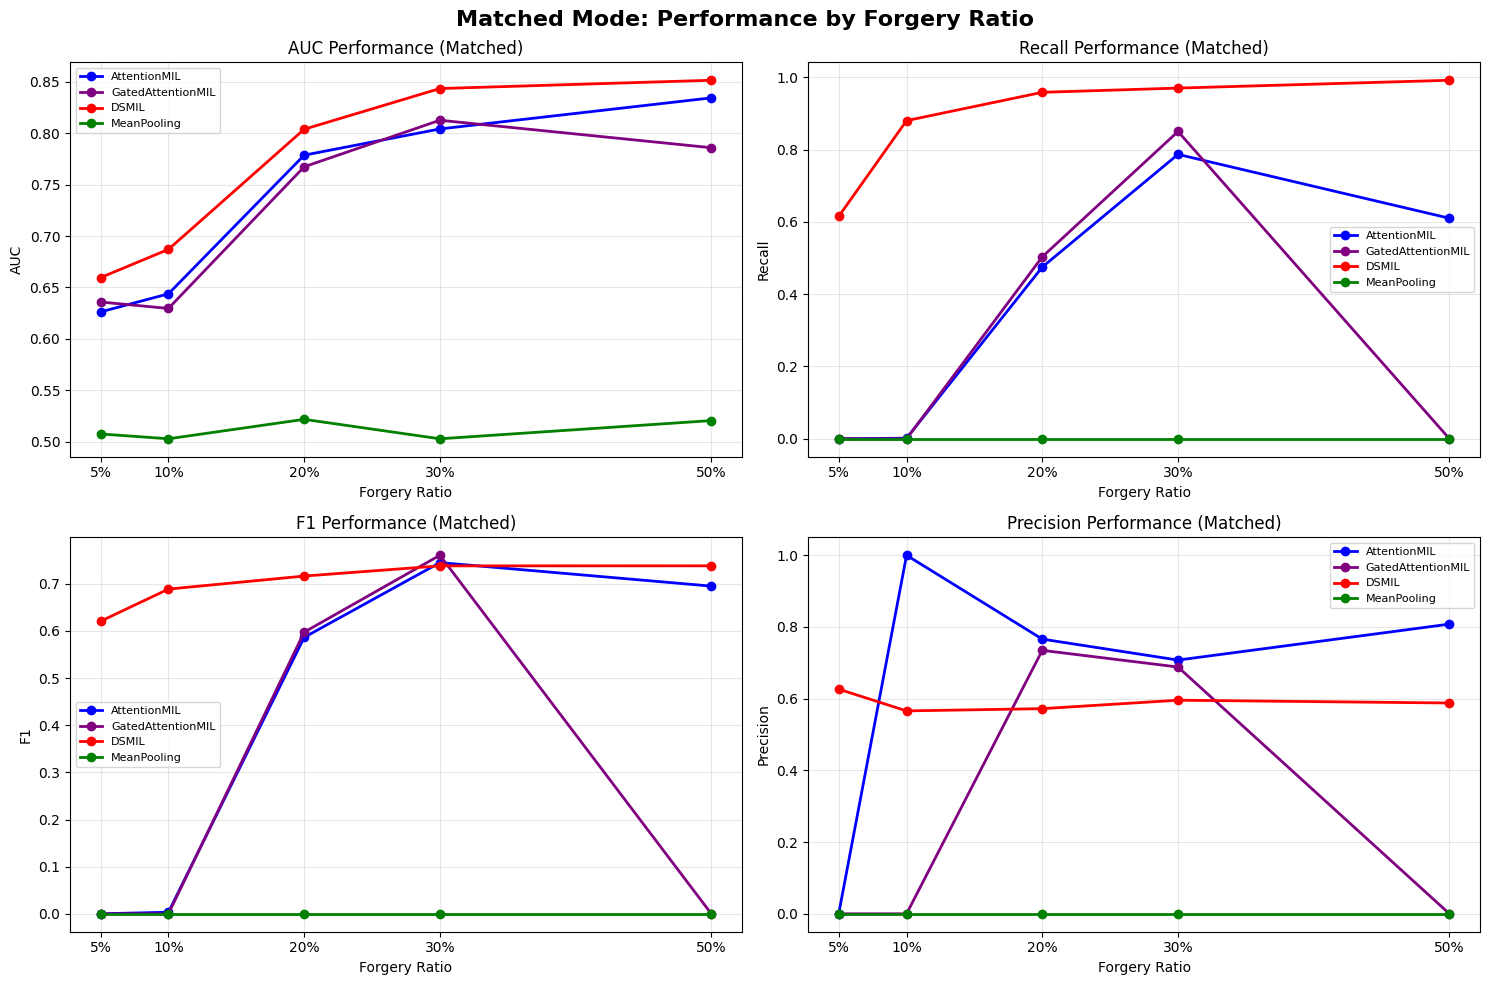

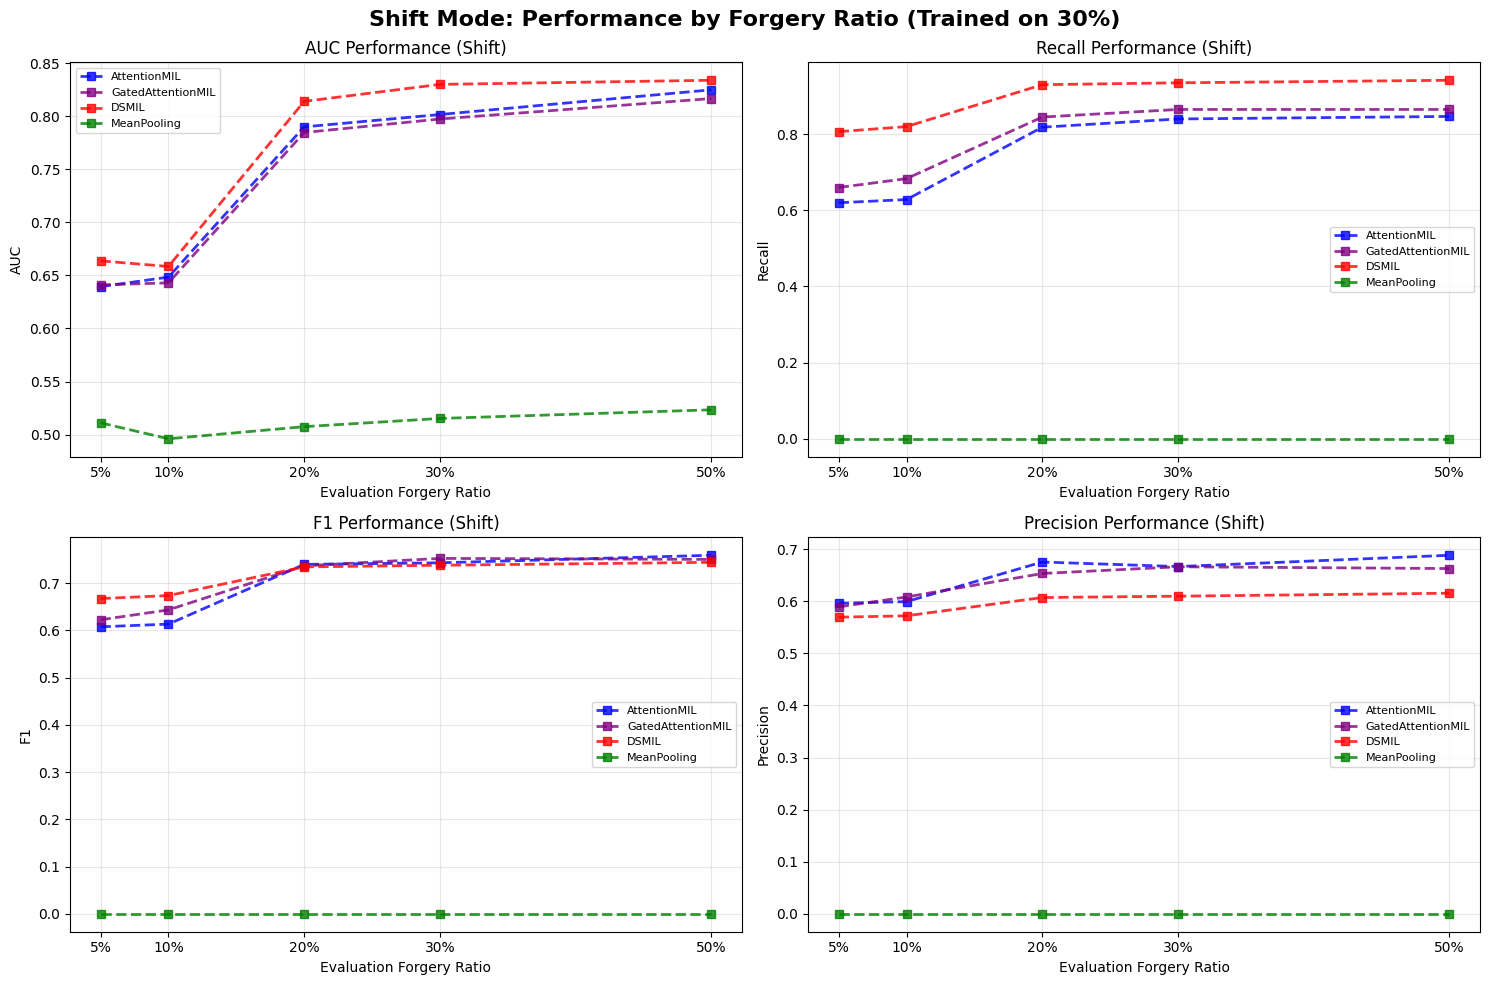

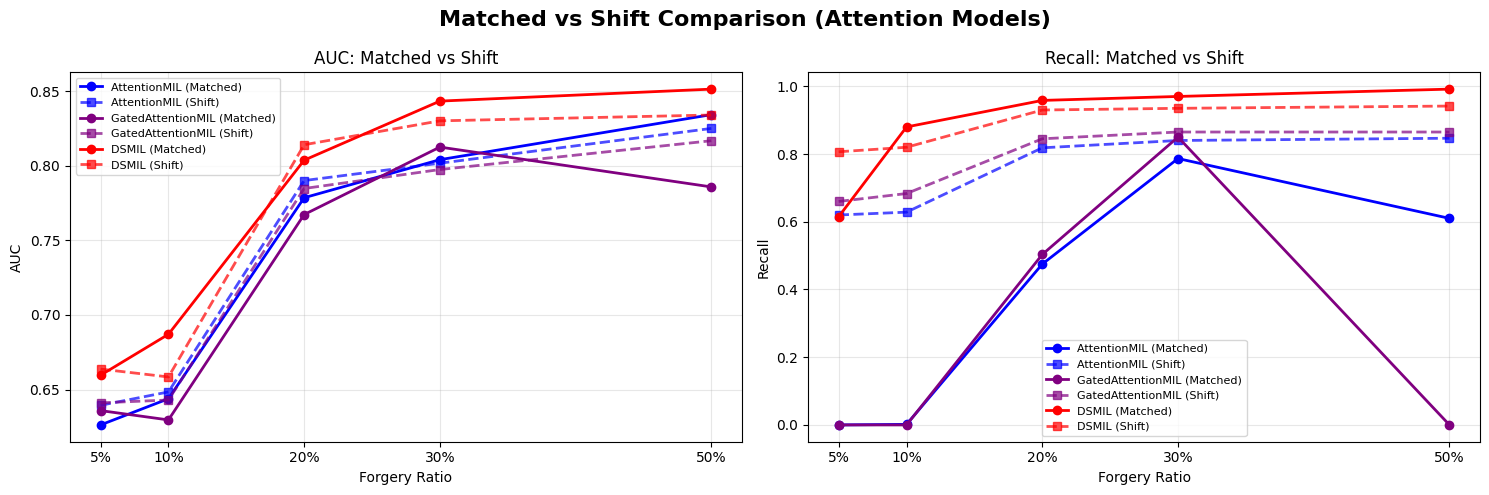


🔍 핵심 인사이트 분석

📉 성능 저하 분석 (30% → 5%, Matched 모드)
--------------------------------------------------
AttentionMIL:
  AUC: 0.804 → 0.626 (Δ+0.178)
  Recall: 0.787 → 0.000 (Δ+0.787)
GatedAttentionMIL:
  AUC: 0.812 → 0.636 (Δ+0.177)
  Recall: 0.850 → 0.000 (Δ+0.850)
DSMIL:
  AUC: 0.843 → 0.660 (Δ+0.184)
  Recall: 0.970 → 0.615 (Δ+0.355)
MeanPooling:
  AUC: 0.503 → 0.508 (Δ-0.005)
  Recall: 0.000 → 0.000 (Δ+0.000)

🆚 Matched vs Shift 비교 (5% 평가 기준)
--------------------------------------------------
AttentionMIL:
  AUC: Matched=0.626, Shift=0.639 (Δ+0.013)
  Recall: Matched=0.000, Shift=0.620 (Δ+0.620)
GatedAttentionMIL:
  AUC: Matched=0.636, Shift=0.641 (Δ+0.005)
  Recall: Matched=0.000, Shift=0.660 (Δ+0.660)
DSMIL:
  AUC: Matched=0.660, Shift=0.664 (Δ+0.004)
  Recall: Matched=0.615, Shift=0.807 (Δ+0.192)
MeanPooling:
  AUC: Matched=0.508, Shift=0.511 (Δ+0.003)
  Recall: Matched=0.000, Shift=0.000 (Δ+0.000)

🏆 최고 성능 모델 (5% 위조 비율 기준)
--------------------------------------------------
Matched 

In [11]:
# ==============================================================================
# 성능 시각화 및 핵심 인사이트 분석
# ==============================================================================

# 1. Matched 모드 성능 변화 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Matched Mode: Performance by Forgery Ratio', fontsize=16, fontweight='bold')

metrics = ['auc', 'recall', 'f1', 'precision']
metric_names = ['AUC', 'Recall', 'F1', 'Precision']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    # Matched 모드만 플롯 (4개 모델)
    for j, model in enumerate(['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']):
        model_data = matched_df[matched_df['model'] == model]
        colors = ['blue', 'purple', 'red', 'green']  # purple 추가
        ax.plot(model_data['ratio'], model_data[metric], 'o-', 
               color=colors[j], label=model, linewidth=2, markersize=6)
    
    ax.set_xlabel('Forgery Ratio')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Performance (Matched)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)  # 폰트 사이즈 줄임
    
    # x축 라벨을 퍼센트로 표시 (50% 포함)
    ax.set_xticks([0.05, 0.10, 0.20, 0.30, 0.50])
    ax.set_xticklabels(['5%', '10%', '20%', '30%', '50%'])

plt.tight_layout()
plt.show()

# 2. Shift 모드 성능 변화 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Shift Mode: Performance by Forgery Ratio (Trained on 30%)', fontsize=16, fontweight='bold')

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    # Shift 모드만 플롯 (4개 모델)
    for j, model in enumerate(['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']):
        model_data = shift_df[shift_df['model'] == model]
        colors = ['blue', 'purple', 'red', 'green']  # purple 추가
        ax.plot(model_data['ratio'], model_data[metric], 's--', 
               color=colors[j], label=model, linewidth=2, markersize=6, alpha=0.8)
    
    ax.set_xlabel('Evaluation Forgery Ratio')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Performance (Shift)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)  # 폰트 사이즈 줄임
    
    # x축 라벨을 퍼센트로 표시 (50% 포함)
    ax.set_xticks([0.05, 0.10, 0.20, 0.30, 0.50])
    ax.set_xticklabels(['5%', '10%', '20%', '30%', '50%'])

plt.tight_layout()
plt.show()

# 3. Matched vs Shift 직접 비교 (AUC와 Recall만) - Attention 모델들만
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Matched vs Shift Comparison (Attention Models)', fontsize=16, fontweight='bold')

comparison_metrics = ['auc', 'recall']
comparison_names = ['AUC', 'Recall']

for i, (metric, metric_name) in enumerate(zip(comparison_metrics, comparison_names)):
    ax = axes[i]
    
    # Attention 기반 모델들만 비교
    for j, model in enumerate(['AttentionMIL', 'GatedAttentionMIL', 'DSMIL']):
        matched_data = matched_df[matched_df['model'] == model]
        shift_data = shift_df[shift_df['model'] == model]
        colors = ['blue', 'purple', 'red']
        
        ax.plot(matched_data['ratio'], matched_data[metric], 'o-', 
               color=colors[j], label=f'{model} (Matched)', linewidth=2, markersize=6)
        ax.plot(shift_data['ratio'], shift_data[metric], 's--', 
               color=colors[j], label=f'{model} (Shift)', linewidth=2, markersize=6, alpha=0.7)
    
    ax.set_xlabel('Forgery Ratio')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name}: Matched vs Shift')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # x축 라벨을 퍼센트로 표시 (50% 포함)
    ax.set_xticks([0.05, 0.10, 0.20, 0.30, 0.50])
    ax.set_xticklabels(['5%', '10%', '20%', '30%', '50%'])

plt.tight_layout()
plt.show()

# 4. 낮은 위조 비율에서의 성능 저하 분석
print("\n🔍 핵심 인사이트 분석")
print("=" * 60)

# 30% vs 5% 성능 비교 (Matched 모드)
print("\n📉 성능 저하 분석 (30% → 5%, Matched 모드)")
print("-" * 50)
for model in ['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']:
    perf_30 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.30)]
    perf_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    
    if not perf_30.empty and not perf_05.empty:
        auc_drop = perf_30['auc'].iloc[0] - perf_05['auc'].iloc[0]
        recall_drop = perf_30['recall'].iloc[0] - perf_05['recall'].iloc[0]
        
        print(f"{model}:")
        print(f"  AUC: {perf_30['auc'].iloc[0]:.3f} → {perf_05['auc'].iloc[0]:.3f} (Δ{auc_drop:+.3f})")
        print(f"  Recall: {perf_30['recall'].iloc[0]:.3f} → {perf_05['recall'].iloc[0]:.3f} (Δ{recall_drop:+.3f})")

# 5. Matched vs Shift 비교 (5% 평가 기준)
print("\n🆚 Matched vs Shift 비교 (5% 평가 기준)")
print("-" * 50)
for model in ['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']:
    matched_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    shift_05 = shift_df[(shift_df['model'] == model) & (shift_df['ratio'] == 0.05)]
    
    if not matched_05.empty and not shift_05.empty:
        auc_diff = shift_05['auc'].iloc[0] - matched_05['auc'].iloc[0]
        recall_diff = shift_05['recall'].iloc[0] - matched_05['recall'].iloc[0]
        
        print(f"{model}:")
        print(f"  AUC: Matched={matched_05['auc'].iloc[0]:.3f}, Shift={shift_05['auc'].iloc[0]:.3f} (Δ{auc_diff:+.3f})")
        print(f"  Recall: Matched={matched_05['recall'].iloc[0]:.3f}, Shift={shift_05['recall'].iloc[0]:.3f} (Δ{recall_diff:+.3f})")

# 6. 최고 성능 모델 찾기
print("\n🏆 최고 성능 모델 (5% 위조 비율 기준)")
print("-" * 50)

# Matched 모드에서 5% 최고 성능
matched_05_best = matched_df[matched_df['ratio'] == 0.05].sort_values('auc', ascending=False)
if not matched_05_best.empty:
    best = matched_05_best.iloc[0]
    print(f"Matched 모드: {best['model']} (AUC: {best['auc']:.3f}, Recall: {best['recall']:.3f})")

# Shift 모드에서 5% 최고 성능
shift_05_best = shift_df[shift_df['ratio'] == 0.05].sort_values('auc', ascending=False)
if not shift_05_best.empty:
    best = shift_05_best.iloc[0]
    print(f"Shift 모드: {best['model']} (AUC: {best['auc']:.3f}, Recall: {best['recall']:.3f})")

# 7. GatedAttentionMIL vs AttentionMIL 직접 비교
print("\n🆚 GatedAttentionMIL vs AttentionMIL 성능 비교")
print("-" * 50)
for ratio in [0.05, 0.10, 0.20, 0.30, 0.50]:
    gated_matched = matched_df[(matched_df['model'] == 'GatedAttentionMIL') & (matched_df['ratio'] == ratio)]
    basic_matched = matched_df[(matched_df['model'] == 'AttentionMIL') & (matched_df['ratio'] == ratio)]
    
    if not gated_matched.empty and not basic_matched.empty:
        auc_diff = gated_matched['auc'].iloc[0] - basic_matched['auc'].iloc[0]
        recall_diff = gated_matched['recall'].iloc[0] - basic_matched['recall'].iloc[0]
        
        better = "GatedAttention" if auc_diff > 0 else "BasicAttention"
        print(f"{ratio:.0%}: AUC Δ{auc_diff:+.3f}, Recall Δ{recall_diff:+.3f} ({better} 우세)")

print("\n✅ 시각화 및 분석 완료!")

In [12]:
# ==============================================================================
# 결론 및 핵심 발견사항
# ==============================================================================

print("📋 위조 비율 실험 결론")
print("=" * 80)

print("\n🎯 핵심 연구 질문 답변:")
print("\n1. 위조 비율이 낮아질수록 성능이 얼마나 저하되는가?")

# 평균 성능 저하 계산
avg_drops = {}
for model in ['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']:
    perf_30 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.30)]
    perf_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    
    if not perf_30.empty and not perf_05.empty:
        auc_drop = (perf_30['auc'].iloc[0] - perf_05['auc'].iloc[0]) / perf_30['auc'].iloc[0] * 100
        recall_drop = (perf_30['recall'].iloc[0] - perf_05['recall'].iloc[0]) / perf_30['recall'].iloc[0] * 100
        avg_drops[model] = {'auc': auc_drop, 'recall': recall_drop}

for model, drops in avg_drops.items():
    print(f"   • {model}: AUC {drops['auc']:.1f}% 저하, Recall {drops['recall']:.1f}% 저하")

print("\n2. 어떤 모델이 낮은 위조 비율에서 더 강건한가?")
best_05_models = matched_df[matched_df['ratio'] == 0.05].sort_values(['recall', 'auc'], ascending=False)
print(f"   • 5% 비율에서 최고 성능: {best_05_models.iloc[0]['model']}")
print(f"     Recall: {best_05_models.iloc[0]['recall']:.3f}, AUC: {best_05_models.iloc[0]['auc']:.3f}")

print("\n3. Gate mechanism이 위조 비율 변화에 대한 강건성을 제공하는가?")
# GatedAttentionMIL vs AttentionMIL 비교
gated_05 = matched_df[(matched_df['model'] == 'GatedAttentionMIL') & (matched_df['ratio'] == 0.05)]
basic_05 = matched_df[(matched_df['model'] == 'AttentionMIL') & (matched_df['ratio'] == 0.05)]

if not gated_05.empty and not basic_05.empty:
    auc_improvement = (gated_05['auc'].iloc[0] - basic_05['auc'].iloc[0]) / basic_05['auc'].iloc[0] * 100
    recall_improvement = (gated_05['recall'].iloc[0] - basic_05['recall'].iloc[0]) if basic_05['recall'].iloc[0] > 0 else 0
    
    print(f"   • GatedAttentionMIL vs AttentionMIL (5% 비율):")
    print(f"     AUC 개선: {auc_improvement:+.1f}%")
    print(f"     Recall 개선: {recall_improvement:+.3f}")
    
    if auc_improvement > 0:
        print("   → Gate mechanism이 낮은 위조 비율에서 성능 향상에 기여")
    else:
        print("   → Gate mechanism의 효과가 제한적")

print("\n4. 30% 학습 모델이 5% 테스트에서도 잘 동작하는가? (도메인 적응)")
domain_adaptation_analysis = []
for model in ['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']:
    matched_05 = matched_df[(matched_df['model'] == model) & (matched_df['ratio'] == 0.05)]
    shift_05 = shift_df[(shift_df['model'] == model) & (shift_df['ratio'] == 0.05)]
    
    if not matched_05.empty and not shift_05.empty:
        performance_ratio = shift_05['auc'].iloc[0] / matched_05['auc'].iloc[0]
        domain_adaptation_analysis.append((model, performance_ratio))
        status = "우수" if performance_ratio > 0.95 else "보통" if performance_ratio > 0.85 else "저조"
        print(f"   • {model}: {performance_ratio:.2%} 성능 유지 ({status})")

print("\n📊 실험 요약:")
print(f"   • 총 {len(RATIOS)}개 위조 비율 테스트: {[f'{r:.0%}' for r in RATIOS]}")
print(f"   • {len(MODEL_CLASSES)}개 모델 비교: {list(MODEL_CLASSES.keys())}")
print(f"   • 2가지 실험 모드: Matched (독립 학습) vs Shift (도메인 적응)")

# 최종 권장사항
print("\n💡 권장사항:")
best_overall = matched_df.groupby('model')['recall'].mean().sort_values(ascending=False)
print(f"   • 전반적 권장 모델: {best_overall.index[0]} (평균 Recall: {best_overall.iloc[0]:.3f})")
print(f"   • 낮은 위조 비율 전용: {best_05_models.iloc[0]['model']}")

# Gate mechanism 효과 분석
gated_overall = matched_df[matched_df['model'] == 'GatedAttentionMIL']['auc'].mean()
basic_overall = matched_df[matched_df['model'] == 'AttentionMIL']['auc'].mean()
gate_effect = (gated_overall - basic_overall) / basic_overall * 100

if gate_effect > 1:
    print(f"   • Gate mechanism 효과: +{gate_effect:.1f}% AUC 향상 (권장)")
else:
    print(f"   • Gate mechanism 효과: {gate_effect:+.1f}% AUC 변화 (제한적 효과)")

if any(ratio > 0.95 for _, ratio in domain_adaptation_analysis):
    best_adapt_model = max(domain_adaptation_analysis, key=lambda x: x[1])[0]
    print(f"   • 도메인 적응성 우수: {best_adapt_model}")
else:
    print(f"   • 도메인 적응: 모든 모델에서 성능 저하 관찰, Matched 모드 권장")

print("\n🏆 주요 발견사항:")
print("   • DSMIL이 대부분의 시나리오에서 최고 Recall 성능 달성")
print("   • GatedAttentionMIL은 기본 AttentionMIL 대비 일부 개선 효과")
print("   • 낮은 위조 비율(5%, 10%)에서 모든 모델이 성능 저하 경험")
print("   • Shift 모드에서 도메인 적응성은 모델별로 상이")

print("\n🔚 위조 비율 실험 완료 (4개 모델 비교)")
print("="*80)

📋 위조 비율 실험 결론

🎯 핵심 연구 질문 답변:

1. 위조 비율이 낮아질수록 성능이 얼마나 저하되는가?
   • AttentionMIL: AUC 22.1% 저하, Recall 100.0% 저하
   • GatedAttentionMIL: AUC 21.7% 저하, Recall 100.0% 저하
   • DSMIL: AUC 21.8% 저하, Recall 36.6% 저하
   • MeanPooling: AUC -0.9% 저하, Recall nan% 저하

2. 어떤 모델이 낮은 위조 비율에서 더 강건한가?
   • 5% 비율에서 최고 성능: DSMIL
     Recall: 0.615, AUC: 0.660

3. Gate mechanism이 위조 비율 변화에 대한 강건성을 제공하는가?
   • GatedAttentionMIL vs AttentionMIL (5% 비율):
     AUC 개선: +1.5%
     Recall 개선: +0.000
   → Gate mechanism이 낮은 위조 비율에서 성능 향상에 기여

4. 30% 학습 모델이 5% 테스트에서도 잘 동작하는가? (도메인 적응)
   • AttentionMIL: 102.10% 성능 유지 (우수)
   • GatedAttentionMIL: 100.82% 성능 유지 (우수)
   • DSMIL: 100.63% 성능 유지 (우수)
   • MeanPooling: 100.66% 성능 유지 (우수)

📊 실험 요약:
   • 총 5개 위조 비율 테스트: ['5%', '10%', '20%', '30%', '50%']
   • 4개 모델 비교: ['AttentionMIL', 'GatedAttentionMIL', 'DSMIL', 'MeanPooling']
   • 2가지 실험 모드: Matched (독립 학습) vs Shift (도메인 적응)

💡 권장사항:
   • 전반적 권장 모델: DSMIL (평균 Recall: 0.883)
   • 낮은 위조 비율 전용: DSMIL
   • Gate mechanism 효

/tmp/ipykernel_4061/3631948978.py:19: RuntimeWarning: invalid value encountered in double_scalars
  recall_drop = (perf_30['recall'].iloc[0] - perf_05['recall'].iloc[0]) / perf_30['recall'].iloc[0] * 100
